#### Competition Link : 
https://www.kaggle.com/competitions/diamond-price-prediciton-2024

#### Team Name : 'ShAI - B'

## Import Libraries

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

## Load Data

In [2]:
# Kaggle
# train_df = pd.read_csv(r"/kaggle/input/diamond-data/train.csv")
# test_df  = pd.read_csv(r"/kaggle/input/diamond-data/test.csv")

# # Jupyter
train_df = pd.read_csv(r"diamond-data/train.csv")
test_df  = pd.read_csv(r"diamond-data/test.csv")

train_df.head(5)

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


## Data Preprocessing

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       43152 non-null  int64  
 1   carat    43152 non-null  float64
 2   cut      43152 non-null  object 
 3   color    43152 non-null  object 
 4   clarity  43152 non-null  object 
 5   depth    43152 non-null  float64
 6   table    43152 non-null  float64
 7   price    43152 non-null  int64  
 8   x        43152 non-null  float64
 9   y        43152 non-null  float64
 10  z        43152 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


In [4]:
train_df.describe()

,Id,carat,depth,table,price,x,y,z
count,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,21576.500000,0.797855,61.747177,57.458347,3929.491912,5.731568,5.735018,3.538568
std,12457.053745,0.473594,1.435454,2.233904,3985.527795,1.121279,1.148809,0.708238
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,10788.750000,0.400000,61.000000,56.000000,947.750000,4.710000,4.720000,2.910000
50%,21576.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,32364.250000,1.040000,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000
max,43152.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [5]:
train_df.describe(include='O')

,cut,color,clarity
count,43152,43152,43152
unique,5,7,8
top,Ideal,G,SI1
freq,17203,9060,10428


### Cleaning

In [6]:
train_df.isna().sum()

Id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [7]:
train_df.duplicated().sum()

0

### Handling

In [8]:
train_df.sample(5)

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
10730,10731,2.00,Premium,I,VS1,61.1,58.0,17436,8.11,8.08,4.95
35422,35423,0.81,Ideal,F,SI2,62.3,54.0,3053,5.94,5.98,3.72
3170,3171,0.71,Ideal,E,VS1,62.3,56.0,3346,5.69,5.74,3.56
29998,29999,0.40,Very Good,F,SI1,62.1,60.0,756,4.66,4.70,2.91
14102,14103,0.52,Very Good,D,VS2,63.4,56.0,1828,5.16,5.09,3.25


In [9]:
# x, y, z Will be replaced with vol, af vol == 0, then handle it with the mean of carat weight in specific range (c-0.1, c+0.1)

def handle_test_xyz(col, df="test_df"):
    sub_test_df = df[df[col] == 0]
    for ID in sub_test_df["Id"]:
        carat_ = float(sub_test_df[sub_test_df["Id"] == ID]["carat"])
        
        carat_min = carat_ - 0.1
        carat_max = carat_ + 0.1
        
        sub_train_df = train_df[(train_df["carat"] >= carat_min) & (train_df["carat"] <= carat_max) ]
        
        df.loc[df["Id"] == ID, col] = sub_train_df[col].mean()
        sub_test_df.loc[sub_test_df["Id"] == ID, col] = sub_train_df[col].mean()

In [10]:
len(train_df[(train_df['z'] == 0) | (train_df['y'] == 0) | (train_df['x'] == 0)])
## Use This Code
# train_df = train_df[train_df['z'] != 0 ]

## Or This Code
handle_test_xyz("x", train_df)
handle_test_xyz("y", train_df)
handle_test_xyz("z", train_df)

##### 

In [11]:
print("Total number of (X & Y & Z) Zeros = " ,len(test_df[(test_df['z'] == 0) | (test_df['y'] == 0) | (test_df['x'] == 0)]))

# Use This Code
# test_df['x'].replace({0 : train_df['x'].mean()}, inplace=True)
# test_df['y'].replace({0 : train_df['y'].mean()}, inplace=True)
# test_df['z'].replace({0 : train_df['z'].mean()}, inplace=True)

## Or This Code
handle_test_xyz("x", test_df)
handle_test_xyz("y", test_df)
handle_test_xyz("z", test_df)

Total number of (X & Y & Z) Zeros =  3


In [12]:
train_df = train_df.drop(["Id"], axis=1)

test_IDs = test_df["Id"]
test_df  = test_df.drop(["Id"], axis=1)

### 

In [13]:
train_df_copy = train_df.copy()

In [14]:
train_df.corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.023944,0.182889,0.921911,0.977903,0.948736,0.957260
depth,0.023944,1.000000,-0.302794,-0.013137,-0.029602,-0.033337,0.090423
table,0.182889,-0.302794,1.000000,0.128501,0.198120,0.185078,0.152592
price,0.921911,-0.013137,0.128501,1.000000,0.887170,0.862955,0.864856
x,0.977903,-0.029602,0.198120,0.887170,1.000000,0.969278,0.971509
y,0.948736,-0.033337,0.185078,0.862955,0.969278,1.000000,0.948605
z,0.957260,0.090423,0.152592,0.864856,0.971509,0.948605,1.000000


In [16]:
train_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


### 

In [17]:
train_df["cut"].unique()

array(['Ideal', 'Premium', 'Very Good', 'Fair', 'Good'], dtype=object)

In [18]:
cut_column_unique_ordered = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']

train_df["cut"].replace({"Fair":0, "Good":1, "Very Good":2, "Premium":3, "Ideal":4}, inplace=True)
test_df ["cut"].replace({"Fair":0, "Good":1, "Very Good":2, "Premium":3, "Ideal":4}, inplace=True)

### 

In [19]:
train_df["color"].unique()

array(['I', 'G', 'F', 'H', 'D', 'E', 'J'], dtype=object)

In [20]:
color_column_unique_ordered = ["J", "I", "H", "G", "F", "E", "D"]

train_df["color"].replace({"J":0, "I":1, "H":2, "G":3, "F":4, "E":5, "D":6}, inplace=True)
test_df ["color"].replace({"J":0, "I":1, "H":2, "G":3, "F":4, "E":5, "D":6}, inplace=True)

#### 

In [21]:
train_df["clarity"].unique()

array(['SI2', 'VVS2', 'VS2', 'IF', 'VS1', 'SI1', 'VVS1', 'I1'],
      dtype=object)

In [22]:
clarity_column_unique_ordered = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

train_df["clarity"].replace({"I1":0, "SI2":1, "SI1":2, "VS2":3, "VS1":4, "VVS2":5, "VVS1":6, "IF":7}, inplace=True)
test_df ["clarity"].replace({"I1":0, "SI2":1, "SI1":2, "VS2":3, "VS1":4, "VVS2":5, "VVS1":6, "IF":7}, inplace=True)

#### 

In [23]:
train_df.head(5)

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Very Good,...,color_E,color_D,clarity_I1,clarity_SI2,clarity_SI1,clarity_VS2,clarity_VS1,clarity_VVS2,clarity_VVS1,clarity_IF
0,1.06,61.8,57.0,4270,6.57,6.60,4.07,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1.51,60.9,58.0,15164,7.38,7.42,4.51,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.32,61.3,56.0,828,4.43,4.41,2.71,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.53,61.2,56.0,1577,5.19,5.22,3.19,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.70,61.0,57.0,2596,5.76,5.72,3.50,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [24]:
test_df.head(5)

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Very Good,cut_Premium,...,color_E,color_D,clarity_I1,clarity_SI2,clarity_SI1,clarity_VS2,clarity_VS1,clarity_VVS2,clarity_VVS1,clarity_IF
0,0.34,61.1,57.0,4.52,4.48,2.75,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.71,62.7,58.0,5.74,5.68,3.58,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
2,0.44,62.8,56.0,4.83,4.88,3.05,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.81,60.1,59.0,6.09,6.03,3.65,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
4,0.40,61.2,56.0,4.74,4.80,2.92,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [25]:
train_df["depth"] = 2 * train_df["z"] / (train_df["x"] + train_df["y"]) * 100
test_df["depth"]  = 2 * test_df["z"]  / (test_df["x"]  + test_df["y"]) * 100

## Data Visualization

<AxesSubplot:>

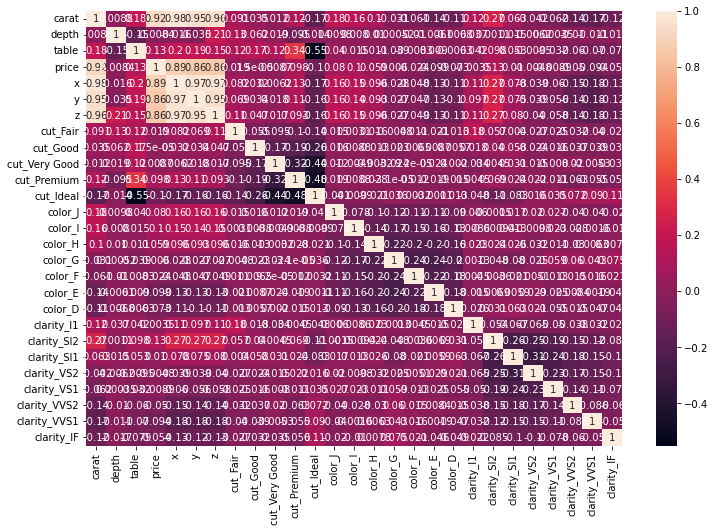

In [26]:
plt.subplots(figsize=(12, 8))
sns.heatmap(train_df.corr(), annot=True)

array([[<AxesSubplot:title={'center':'carat'}>,
        <AxesSubplot:title={'center':'depth'}>,
        <AxesSubplot:title={'center':'table'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'x'}>],
       [<AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'cut_Fair'}>,
        <AxesSubplot:title={'center':'cut_Good'}>,
        <AxesSubplot:title={'center':'cut_Very Good'}>],
       [<AxesSubplot:title={'center':'cut_Premium'}>,
        <AxesSubplot:title={'center':'cut_Ideal'}>,
        <AxesSubplot:title={'center':'color_J'}>,
        <AxesSubplot:title={'center':'color_I'}>,
        <AxesSubplot:title={'center':'color_H'}>],
       [<AxesSubplot:title={'center':'color_G'}>,
        <AxesSubplot:title={'center':'color_F'}>,
        <AxesSubplot:title={'center':'color_E'}>,
        <AxesSubplot:title={'center':'color_D'}>,
        <AxesSubplot:title={'center':'clarity_I1'}>],
     

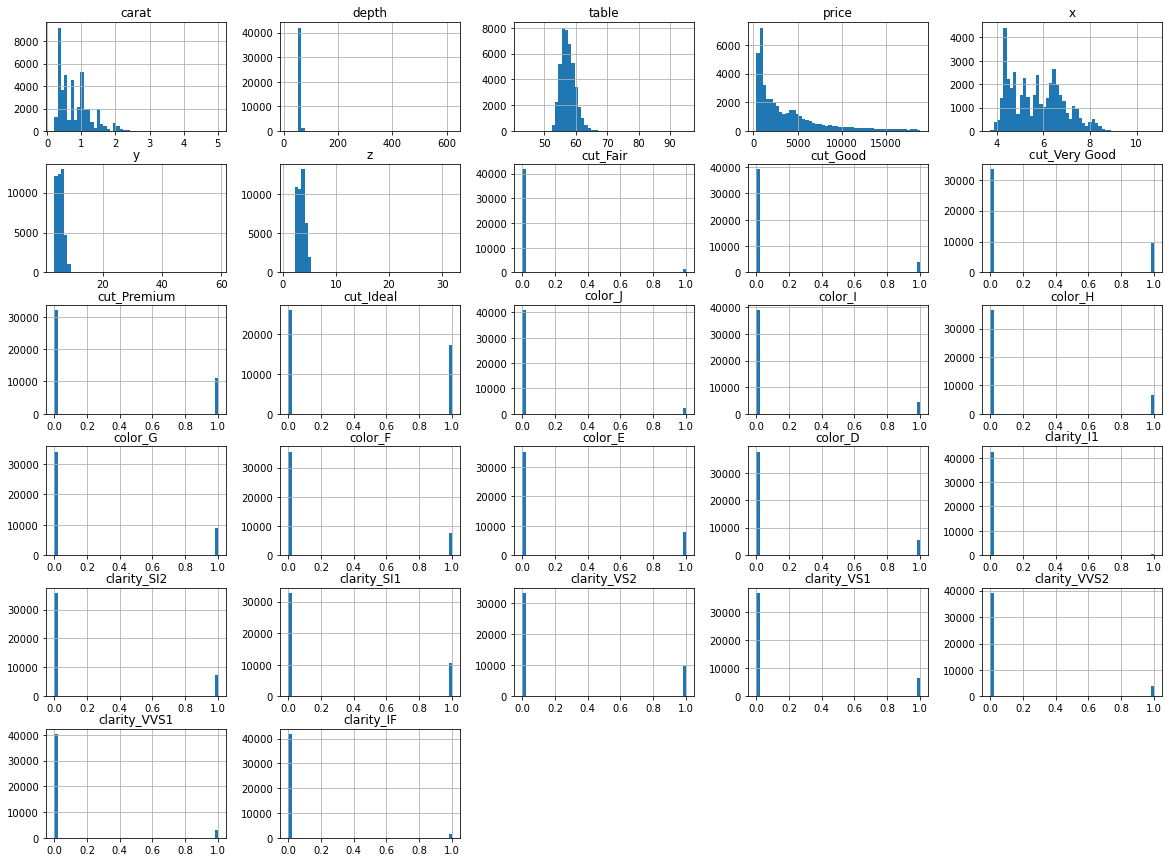

In [27]:
train_df.iloc[:, :].hist(figsize=(20, 15), bins=50)

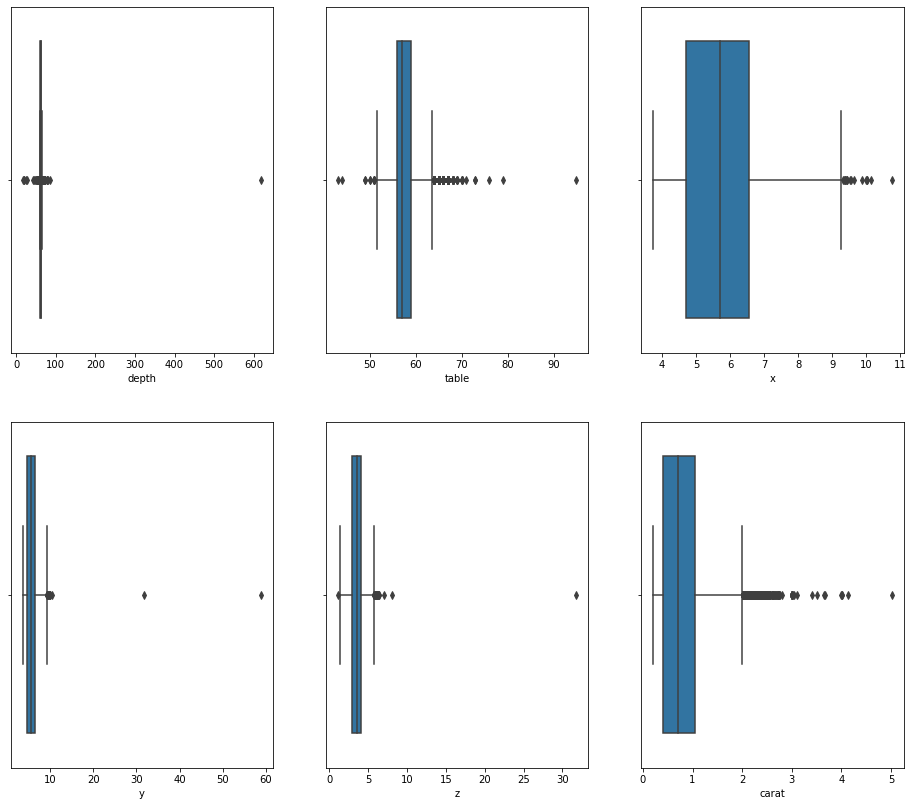

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(16, 14))
for i, cols in enumerate(["carat","depth", "table", "x", "y", "z"], 1):
    sns.boxplot(data=train_df, x=cols)
    plt.subplot(2, 3, i)

plt.show()

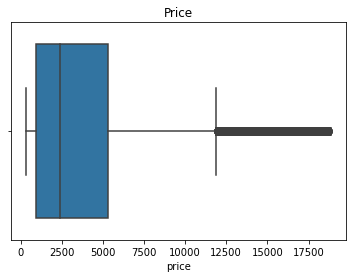

In [29]:
sns.boxplot(data=train_df, x="price")
plt.title("Price")
plt.show()

In [30]:
def get_outliers(col, train_df = train_df):
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    iqr_outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)]
    
    return lower_bound, upper_bound,len(iqr_outliers)


for col in train_df.columns[:7]:
    lower_bound, upper_bound, outliers = get_outliers(col)
    print(f"Number of outliers detected based on IQR method ({str(col).center(8)}) : ", str(outliers).rjust(4), f"Lower = {str(round(lower_bound, 3)).rjust(10)}", f"Upper = {str(round(upper_bound, 2)).rjust(10)}")        

Number of outliers detected based on IQR method ( carat  ) :  1504 Lower =      -0.56 Upper =        2.0
Number of outliers detected based on IQR method ( depth  ) :  2182 Lower =     58.813 Upper =      64.76
Number of outliers detected based on IQR method ( table  ) :   472 Lower =       51.5 Upper =       63.5
Number of outliers detected based on IQR method ( price  ) :  2844 Lower =  -5598.625 Upper =   11858.38
Number of outliers detected based on IQR method (   x    ) :    16 Lower =      1.965 Upper =       9.28
Number of outliers detected based on IQR method (   y    ) :    15 Lower =       1.99 Upper =       9.27
Number of outliers detected based on IQR method (   z    ) :    22 Lower =      1.215 Upper =       5.74


### Outliers Handling

<AxesSubplot:xlabel='carat', ylabel='price'>

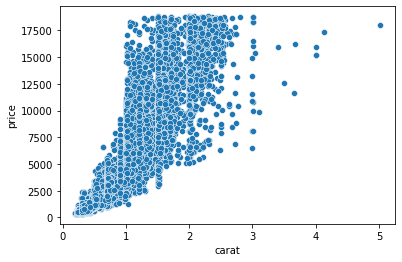

In [31]:
sns.scatterplot(x=train_df["carat"], y=train_df["price"])

In [32]:
print(f"Carat Outliers : {len(train_df[train_df['carat'] > 3])}") # Visualization
train_df = train_df[train_df["carat"] <= 3 ] # 3

Carat Outliers : 21


#### 

<AxesSubplot:xlabel='depth', ylabel='price'>

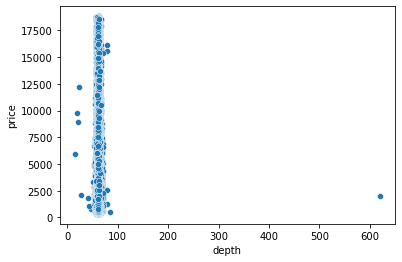

In [33]:
sns.scatterplot(x=train_df["depth"], y=train_df["price"])

In [34]:
print(f"Depth Outliers : {len(train_df[(train_df['depth'] < 50) | (train_df['depth'] > 75)])}") # Visualization
train_df = train_df[(train_df["depth"] >= 50) & (train_df["depth"] <= 75)] # Visulization

Depth Outliers : 14


##### 

<AxesSubplot:xlabel='table', ylabel='price'>

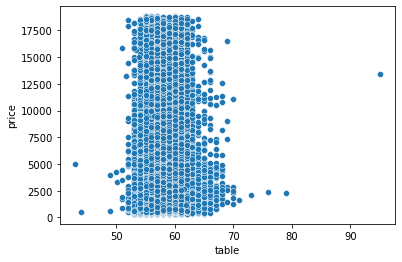

In [35]:
sns.scatterplot(x=train_df["table"], y=train_df["price"])

In [36]:
print(f"Table Outliers : {len(train_df[(train_df['table'] < 50) | (train_df['table'] > 70)])}") # Visualization
train_df = train_df[(train_df["table"] >= 50) & (train_df["table"] <= 70)] # Visulization

Table Outliers : 9


### 

<AxesSubplot:xlabel='x', ylabel='price'>

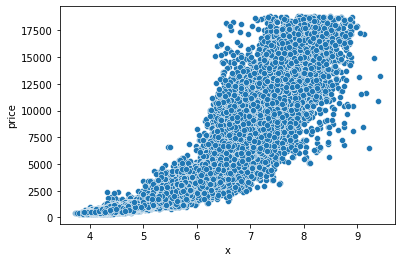

In [37]:
sns.scatterplot(data=train_df, x="x", y="price")

In [38]:
print(f"X Outliers : {len(train_df[train_df['x'] > 9])}") # Visualization
train_df = train_df[train_df["x"] <= 9]

X Outliers : 10


### 

<AxesSubplot:xlabel='y', ylabel='price'>

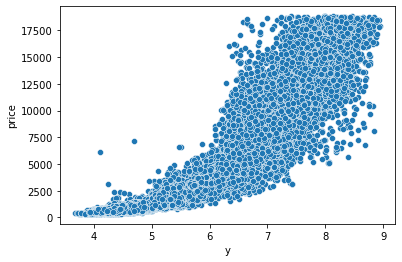

In [39]:
sns.scatterplot(data=train_df, x="y", y="price")

In [40]:
print(f"Y Outliers : {len(train_df[train_df['y'] > 10])}") # Visualization
train_df = train_df[train_df["x"] <= 9]

Y Outliers : 0


### 

<AxesSubplot:xlabel='z', ylabel='price'>

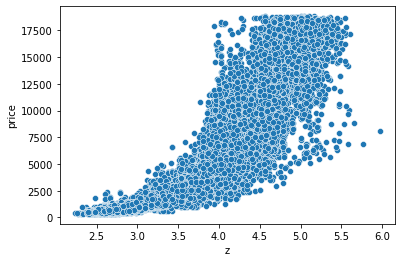

In [41]:
sns.scatterplot(data=train_df, x="z", y="price")

In [42]:
print(f"Z Outliers : {len(train_df[(train_df['z'] < 2) | (train_df['z'] > 7)])}") # Visualization
train_df = train_df[(train_df["z"] >= 2) & (train_df["z"] <= 7)]

Z Outliers : 0


#### 

<AxesSubplot:>

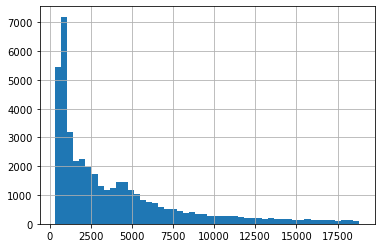

In [43]:
train_df["price"].hist(bins=50)

In [44]:
# train_df = train_df[train_df["price"] <= 11857] # Visulization

### 

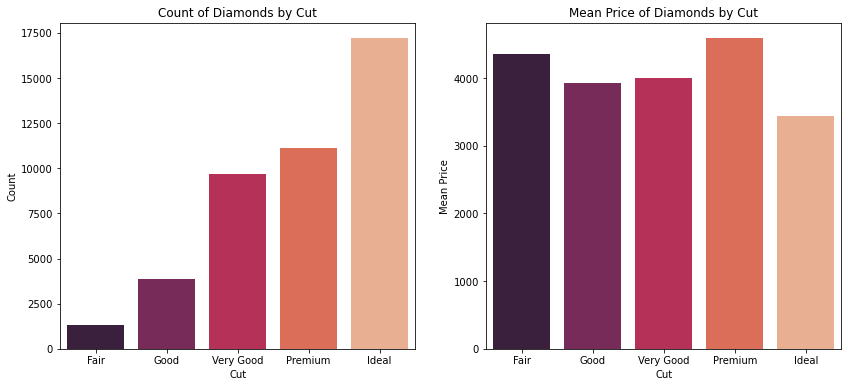

In [45]:
mean_price_by_cut = train_df_copy.groupby("cut")["price"].mean().reindex(cut_column_unique_ordered)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(data=train_df_copy, x="cut", order=cut_column_unique_ordered, ax=axes[0], palette='rocket')
axes[0].set_title("Count of Diamonds by Cut")
axes[0].set_xlabel("Cut")
axes[0].set_ylabel("Count")

sns.barplot(x=mean_price_by_cut.index, y=mean_price_by_cut.values, ax=axes[1], palette='rocket')
axes[1].set_title("Mean Price of Diamonds by Cut")
axes[1].set_xlabel("Cut")
axes[1].set_ylabel("Mean Price")

# # Adjust layout
# plt.tight_layout()

# Show plot
plt.show()

### 

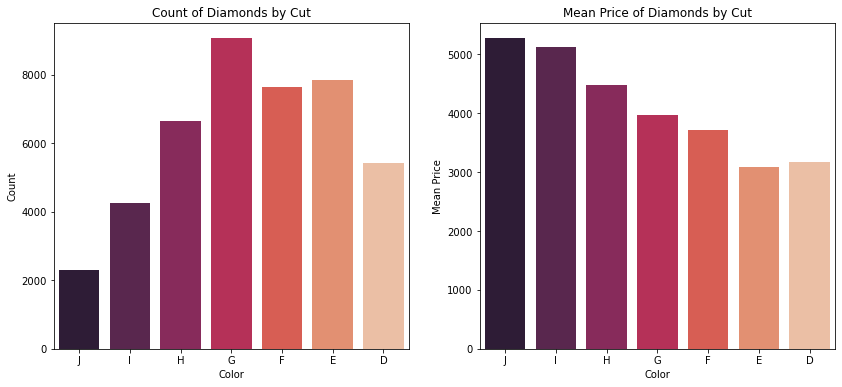

In [46]:
mean_price_by_color = train_df_copy.groupby("color")["price"].mean().reindex(color_column_unique_ordered)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(data=train_df_copy, x="color", order=color_column_unique_ordered, ax=axes[0], palette='rocket')
axes[0].set_title("Count of Diamonds by Cut")
axes[0].set_xlabel("Color")
axes[0].set_ylabel("Count")

sns.barplot(x=mean_price_by_color.index, y=mean_price_by_color.values, ax=axes[1], palette='rocket')
axes[1].set_title("Mean Price of Diamonds by Cut")
axes[1].set_xlabel("Color")
axes[1].set_ylabel("Mean Price")

# # Adjust layout
# plt.tight_layout()

# Show plot
plt.show()

### 

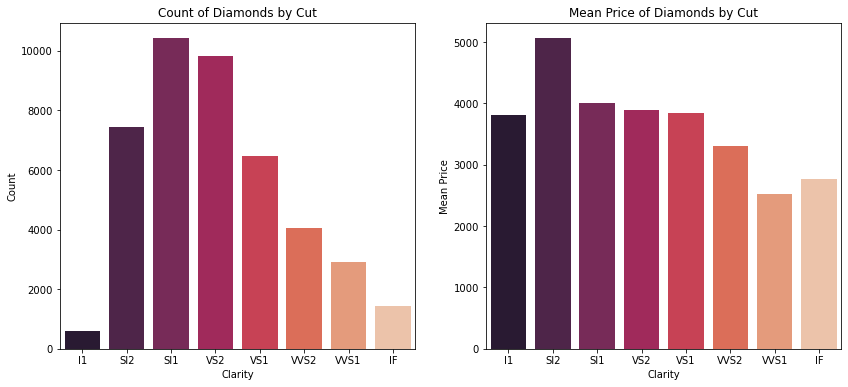

In [47]:
mean_price_by_clarity = train_df_copy.groupby("clarity")["price"].mean().reindex(clarity_column_unique_ordered)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(data=train_df_copy, x="clarity", order=clarity_column_unique_ordered, ax=axes[0], palette='rocket')
axes[0].set_title("Count of Diamonds by Cut")
axes[0].set_xlabel("Clarity")
axes[0].set_ylabel("Count")

sns.barplot(x=mean_price_by_clarity.index, y=mean_price_by_clarity.values, ax=axes[1], palette='rocket')
axes[1].set_title("Mean Price of Diamonds by Cut")
axes[1].set_xlabel("Clarity")
axes[1].set_ylabel("Mean Price")

# # Adjust layout
# plt.tight_layout()

# Show plot
plt.show()

### 

## Feature Engineering 

In [48]:
train_df_copy["vol"] = train_df_copy["x"] * train_df_copy["y"] * train_df_copy["z"] # For Categorical Visualization
# train_df_copy.drop(["x", "y", "z"], axis=1, inplace=True)

train_df["vol"] = train_df["x"] * train_df["y"] * train_df["z"]                     # For Training
train_df.drop(["x", "y", "z"], axis=1, inplace=True)

test_df["vol"] = test_df["x"] * test_df["y"] * test_df["z"]                         # For Testing
test_df.drop(["x", "y", "z"], axis=1, inplace=True)

In [49]:
train_df.corr()["price"].sort_values(ascending=False)

price            1.000000
vol              0.925684
carat            0.923804
clarity_SI2      0.128707
table            0.128216
color_I          0.098641
cut_Premium      0.097179
color_J          0.077814
color_H          0.059374
cut_Fair         0.016751
clarity_SI1      0.011478
cut_Very Good    0.009531
color_G          0.006787
cut_Good        -0.000108
clarity_VS2     -0.003596
clarity_VS1     -0.008029
depth           -0.012523
clarity_I1      -0.012554
color_F         -0.023788
clarity_VVS2    -0.049163
clarity_IF      -0.054163
color_D         -0.072662
clarity_VVS1    -0.094147
color_E         -0.098256
cut_Ideal       -0.100636
Name: price, dtype: float64

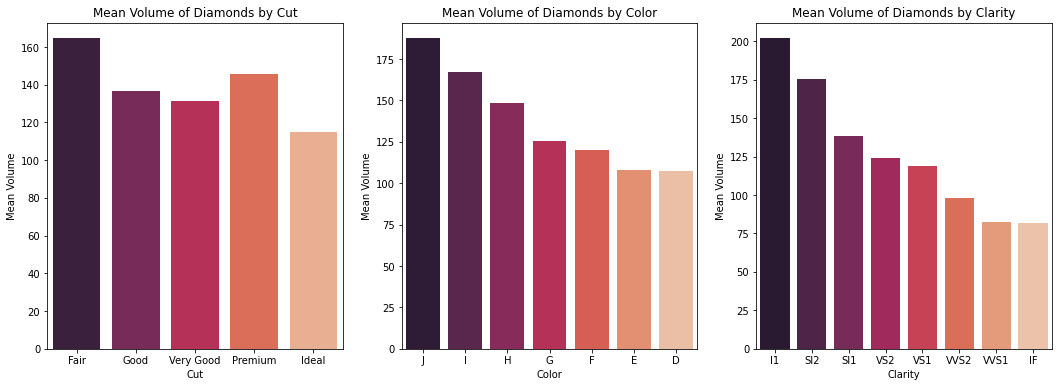

In [50]:
mean_vol_by_cut     = train_df_copy.groupby("cut")["vol"].mean().reindex(cut_column_unique_ordered)
mean_vol_by_color   = train_df_copy.groupby("color")["vol"].mean().reindex(color_column_unique_ordered)
mean_vol_by_clarity = train_df_copy.groupby("clarity")["vol"].mean().reindex(clarity_column_unique_ordered)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Mean volume by cut
sns.barplot(x=mean_vol_by_cut.index, y=mean_vol_by_cut.values, palette='rocket', ax=axes[0])
axes[0].set_title("Mean Volume of Diamonds by Cut")
axes[0].set_xlabel("Cut")
axes[0].set_ylabel("Mean Volume")

# Mean volume by color
sns.barplot(x=mean_vol_by_color.index, y=mean_vol_by_color.values, palette='rocket', ax=axes[1])
axes[1].set_title("Mean Volume of Diamonds by Color")
axes[1].set_xlabel("Color")
axes[1].set_ylabel("Mean Volume")

# Mean volume by clarity
sns.barplot(x=mean_vol_by_clarity.index, y=mean_vol_by_clarity.values, palette='rocket', ax=axes[2])
axes[2].set_title("Mean Volume of Diamonds by Clarity")
axes[2].set_xlabel("Clarity")
axes[2].set_ylabel("Mean Volume")

## Adjust layout
# plt.tight_layout()

# Show plot
plt.show()

In [51]:
train_df.sample(3)

,carat,depth,table,price,cut_Fair,cut_Good,cut_Very Good,cut_Premium,cut_Ideal,color_J,...,color_D,clarity_I1,clarity_SI2,clarity_SI1,clarity_VS2,clarity_VS1,clarity_VVS2,clarity_VVS1,clarity_IF,vol
22715,0.40,62.911796,56.0,807,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,65.524928
18333,1.15,61.721068,57.0,5891,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,188.977152
3692,0.30,62.165308,57.0,665,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,49.252956


In [52]:
test_df.sample(3)

,carat,depth,table,cut_Fair,cut_Good,cut_Very Good,cut_Premium,cut_Ideal,color_J,color_I,...,color_D,clarity_I1,clarity_SI2,clarity_SI1,clarity_VS2,clarity_VS1,clarity_VVS2,clarity_VVS1,clarity_IF,vol
1955,1.51,62.134602,55.0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,247.215978
10117,0.34,62.612613,55.0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,54.803530
4245,0.53,61.909354,57.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,86.297640


### 

## Scaling & Spliting 

### Scaling

In [53]:
y = train_df["price"]
X = train_df.drop(["price"], axis=1)

In [54]:
scaler = StandardScaler()
scaler.fit(X)

scaled_X = scaler.fit_transform(X)
submission_data = scaler.fit_transform(test_df)

In [56]:
train_df.head()

,carat,depth,table,price,cut_Fair,cut_Good,cut_Very Good,cut_Premium,cut_Ideal,color_J,...,color_D,clarity_I1,clarity_SI2,clarity_SI1,clarity_VS2,clarity_VS1,clarity_VVS2,clarity_VVS1,clarity_IF,vol
0,1.06,61.807137,57.0,4270,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,176.483340
1,1.51,60.945946,58.0,15164,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,246.965796
2,0.32,61.312217,56.0,828,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,52.943373
3,0.53,61.287224,56.0,1577,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,86.422842
4,0.70,60.975610,57.0,2596,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,115.315200


### Spliting

In [57]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, random_state=42, test_size = 0.02)

In [58]:
len(X_train)

42236

### 

## Model Selection & Training

#### 1-  Linear Regression

In [59]:
from sklearn.linear_model import LinearRegression

linearReg_model = LinearRegression()
linearReg_model.fit(X_train, y_train)

linearReg_y_pred = linearReg_model.predict(X_test)
linearReg_RMSE = np.sqrt(mean_squared_error(y_test, linearReg_y_pred))
linearReg_MAE = mean_absolute_error(y_test, linearReg_y_pred)


print("Linear Regression RMSE :", linearReg_RMSE)
print("Linear Regression MAE  :", linearReg_MAE, "\n")

for index, (real_value, predicted_value) in zip(range(10), zip(y_test, linearReg_y_pred)):
    print(f"Real value is {str(round(real_value)).rjust(5)} | The predicted value is {str(round(predicted_value)).rjust(5)}")
    
# 1530.215786802567

Linear Regression RMSE : 1149.382783270803
Linear Regression MAE  : 808.3403094844729 

Real value is  3390 | The predicted value is  3870
Real value is  3140 | The predicted value is  3646
Real value is  2639 | The predicted value is  3100
Real value is   658 | The predicted value is   308
Real value is  1125 | The predicted value is  1217
Real value is  1943 | The predicted value is  2705
Real value is   449 | The predicted value is  -826
Real value is   971 | The predicted value is  1789
Real value is   765 | The predicted value is   304
Real value is 14476 | The predicted value is 14442


#### 2- Gradient Boosting

In [60]:
from sklearn.ensemble import GradientBoostingRegressor

gradientBoosting_model = GradientBoostingRegressor(random_state=42)
gradientBoosting_model.fit(X_train, y_train)

gradientBoosting_y_pred = gradientBoosting_model.predict(X_test)
gradientBoosting_RMSE = np.sqrt(mean_squared_error(y_test, gradientBoosting_y_pred))
gradientBoosting_MAE = mean_absolute_error(y_test, gradientBoosting_y_pred)

print("Gradient Boosting RMSE:", gradientBoosting_RMSE)
print("Gradient Boosting MAE  :", gradientBoosting_MAE, "\n")

for index, (real_value, predicted_value) in zip(range(10), zip(y_test, gradientBoosting_y_pred)):
    print(f"Real value is {str(round(real_value)).rjust(5)} | The predicted value is {str(round(predicted_value)).rjust(5)}")

Gradient Boosting RMSE: 739.501627530851
Gradient Boosting MAE  : 398.96433464701533 

Real value is  3390 | The predicted value is  3237
Real value is  3140 | The predicted value is  2846
Real value is  2639 | The predicted value is  3284
Real value is   658 | The predicted value is   850
Real value is  1125 | The predicted value is  1001
Real value is  1943 | The predicted value is  1927
Real value is   449 | The predicted value is   432
Real value is   971 | The predicted value is  1146
Real value is   765 | The predicted value is   830
Real value is 14476 | The predicted value is 15921


#### 3-  Decision Tree

In [61]:
from sklearn.tree import DecisionTreeRegressor

decisionTree_model = DecisionTreeRegressor()
decisionTree_model.fit(X_train, y_train)

decisionTree_y_pred = decisionTree_model.predict(X_test)
decisionTree_RMSE = np.sqrt(mean_squared_error(y_test, decisionTree_y_pred))
decisionTree_MAE = mean_absolute_error(y_test, decisionTree_y_pred)

print("Decision Tree RMSE :", decisionTree_RMSE)
print("Decision Tree MAE  :", decisionTree_MAE, "\n")

for index, (real_value, predicted_value) in zip(range(10), zip(y_test, decisionTree_y_pred)):    
    print(f"Real value is {str(round(real_value)).rjust(5)} | The predicted value is {str(round(predicted_value)).rjust(5)}")

# 722.8128493054971

Decision Tree RMSE : 783.4701016424104
Decision Tree MAE  : 368.460170146945 

Real value is  3390 | The predicted value is  3780
Real value is  3140 | The predicted value is  2606
Real value is  2639 | The predicted value is  3084
Real value is   658 | The predicted value is   658
Real value is  1125 | The predicted value is   877
Real value is  1943 | The predicted value is  1867
Real value is   449 | The predicted value is   576
Real value is   971 | The predicted value is  1004
Real value is   765 | The predicted value is   680
Real value is 14476 | The predicted value is 13786


#### 4-  Random Forest

In [62]:
from sklearn.ensemble import RandomForestRegressor

randomForest_model = RandomForestRegressor(n_estimators=200, random_state=42)
randomForest_model.fit(X_train, y_train)

randomForest_y_pred = randomForest_model.predict(X_test)
randomForest_RMSE = np.sqrt(mean_squared_error(y_test, randomForest_y_pred))
randomForest_MAE  = mean_absolute_error(y_test, randomForest_y_pred)

print("Random Forest RMSE :", randomForest_RMSE)
print("Random Forest MAE  :", randomForest_MAE)

for index, (real_value, predicted_value) in zip(range(1, 20), zip(y_test, randomForest_y_pred)):        
    print(f"Real value is {str(round(real_value)).rjust(5)} | The predicted value is {str(round(predicted_value)).rjust(5)}")

# 536.40 Best on train_df and test_df
# 556.98 Last

Random Forest RMSE : 536.614100370882
Random Forest MAE  : 267.1928518673741
Real value is  3390 | The predicted value is  3336
Real value is  3140 | The predicted value is  2750
Real value is  2639 | The predicted value is  3151
Real value is   658 | The predicted value is   717
Real value is  1125 | The predicted value is   895
Real value is  1943 | The predicted value is  1910
Real value is   449 | The predicted value is   545
Real value is   971 | The predicted value is  1079
Real value is   765 | The predicted value is   682
Real value is 14476 | The predicted value is 16559
Real value is  2496 | The predicted value is  2500
Real value is  6023 | The predicted value is  6257
Real value is   600 | The predicted value is   656
Real value is 16171 | The predicted value is 17437
Real value is   475 | The predicted value is   509
Real value is  5292 | The predicted value is  4613
Real value is  2772 | The predicted value is  3033
Real value is  5599 | The predicted value is  5838
Real 

In [63]:
"""
    ---------------------------------------------------------------------------------------------------------------------
                      Which one is best for use with `44k` rows and about `10` columns (3 categorical columns)
    
The best regression model to use would likely be `Random Forest Regression`

Here's why Random Forest Regression is a strong candidate:

    * Scalability: Random Forests can handle large datasets efficiently, making them suitable for datasets with 44k rows.
    * Feature Importance: Random Forests provide feature importance scores, which can help identify the most influential features in predicting the target variable.
    * Non-linearity: Random Forests can capture non-linear relationships between features and the target variable effectively, which is beneficial when dealing with datasets with complex relationships.
    * Categorical Features: Random Forests can handle categorical features without requiring extensive preprocessing, making them convenient for datasets with categorical columns.
    * Robustness: Random Forests are robust to outliers and noise in the data, reducing the risk of overfitting.
"""
""

''

### 

## Model Evaluation

In [64]:
# forest_model = RandomForestRegressor()
# forest_scores = cross_val_score(forest_model, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5)
# forest_rmse_scores = np.sqrt(np.abs(forest_scores))

In [65]:
# for score in forest_rmse_scores:
#     print(round(score, 3))

## Model Fine-Tune 

In [66]:
# param_grid = {
#     'n_estimators': [50, 100],
#     'max_features': [2, 3],
#     'max_depth'   : [None],
#     'min_samples_split' : [2, 5],
#     'min_samples_leaf'  : [1, 2],
# }


# forest_reg1 = RandomForestRegressor(random_state = 42)

# grid_search1 = GridSearchCV(forest_reg1, param_grid, cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True)
# grid_search1.fit(X_train, y_train)

In [67]:
# cvres = grid_search1.cv_results_

# for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]):
#     print(round(np.sqrt(np.abs(mean_score)), 2), params)

In [68]:
# feature_importances = grid_search1.best_estimator_.feature_importances_
# feature_importances

In [69]:
# # Plotting feature importances
# plt.figure(figsize=(10, 6))
# plt.bar(X.columns, feature_importances)
# plt.xlabel('Features')
# plt.ylabel('Feature Importance')
# plt.show()

In [70]:
# best_model2 = grid_search1.best_estimator_
# # joblib.dump(best_model2, 'RandomForest_TheBest2.pkl')

In [71]:
# best_predictions = best_model2.predict(X_test)
# mse = mean_squared_error(y_test, best_predictions)
# rmse = np.sqrt(np.abs(mse))
# rmse

In [72]:
# np.sqrt(abs(mean_squared_error(y_test, best_model.predict(X_test))))

## Final Prediction

In [73]:
best_predictions2 = randomForest_model.predict(submission_data) # best_model2

In [74]:
for index, pred in zip(range(1, 20), best_predictions2):
    print(f"{str(index).rjust(2)} - ", str(round(pred, 1)).rjust(7))

 1 -    801.0
 2 -   2968.8
 3 -    914.7
 4 -   2761.6
 5 -   1080.3
 6 -  10309.6
 7 -   5795.7
 8 -   4408.7
 9 -   2240.5
10 -    747.0
11 -   1717.7
12 -   1494.9
13 -   4368.9
14 -   5184.3
15 -   1124.5
16 -   2691.5
17 -   2388.9
18 -  12479.3
19 -   4532.4


## Submission Dataset

In [75]:
# Dataset contains 2 columns | 1st one is the ID, 2nd one is the prediction

data_for_sub = pd.DataFrame({"ID":test_IDs, "price":best_predictions2})
data_for_sub.to_csv("Submission 13 RF.csv", index=False)

In [76]:
# train_df.sample()

In [77]:
"""
1 -  986.27
2 -  2877.73
3 -  876.51
4 -  2719.93
5 -  1073.95
6 -  11091.41
7 -  5920.16
8 -  4385.69
9 -  2154.38
10 -  841.0
11 -  1699.73
12 -  1480.01
13 -  4175.6
14 -  5212.63
15 -  1185.67
16 -  2460.68
17 -  2367.46
18 -  13243.64
19 -  4666.29
20 -  5179.32
21 -  1928.31
22 -  1021.42
23 -  847.8276666666666
24 -  1300.83
25 -  6309.79
26 -  3067.32
27 -  12891.0
"""
""

''